# Anomaly detection for higher-order interactions

While graphs (or the associated matrices) can seem adequate for representing authentication events on a global scale, they actually fall short of encoding all the relevant information contained in the logs.
In particular, a remote authentication should be characterized by at least three elements: the user, the source host and the destination host.
Additional information, such as the authentication package or logon type, can be useful as well.
We thus need a more sophisticated representation in order to factor in all these characteristics.

To that end, it seems reasonable to consider the natural extension of matrices to higher-order interactions, namely tensors.
In this notebook, we thus explore the use of probabilistic tensor decomposition for intrusion detection in event logs.
In particular, we study the impact of including more fields in our representation of an event, focusing on the trade-off between the gain in data separability and the incident increase in model complexity.

In [20]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#print(module_path)

#import sys  
#sys.path.insert(0, '/home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection/pyCP_APR/pyCP_APR/')

#import pyCP_APR

#import /home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection/pyCP_APR/pyCP_APR/pyCP_APR.py

In [25]:
sys.path.append(".")

print(sys.path)

from pyCP_APR import CP_APR

['/home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection/pyCP_APR/pyCP_APR/', '/home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection/pyCP_APR/pyCP_APR/', '/home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection/pyCP_APR/pyCP_APR/', '/home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection/notebooks', '/home/craftdata/anaconda3/lib/python38.zip', '/home/craftdata/anaconda3/lib/python3.8', '/home/craftdata/anaconda3/lib/python3.8/lib-dynload', '', '/home/craftdata/.local/lib/python3.8/site-packages', '/home/craftdata/anaconda3/lib/python3.8/site-packages', '/home/craftdata/anaconda3/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/home/craftdata/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/home/craftdata/.ipython', '/home/craftdata/Documents/Plateforme_de_calcul/OVH/Notebooks/Anomaly-Detection', '.', '.', '.', '.']


ImportError: cannot import name 'CP_APR' from 'pyCP_APR' (unknown location)

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyCP_APR import CP_APR

from scipy.stats import poisson

from utils import evaluate_algo, evaluate_algo_events

ImportError: cannot import name 'CP_APR' from 'pyCP_APR' (unknown location)

In [2]:
seed = 123
np.random.seed(seed)

In [3]:
dir_path = os.path.join('data', 'event_tensors')

The dataset now consists of two 5-mode tensors (one for the training period and one for the test period).
The modes represent the user, the source host, the destination host, the authentication package and the logon type, respectively.
Note that hosts which appear as both sources and destinations are represented by two separate indices, one in the source mode and one in the destination mode.
The coefficient at location $(u,s,d,a,t)$ represents the number of events involving user $u$, source $s$, destination $d$, authentication package $a$ and logon type $t$.

In [4]:
train = pd.read_csv(                          # Read interaction tensor for the training period
    os.path.join(dir_path, 'train.csv')
)

test = pd.read_csv(                           # Read interaction tensor for the test period
    os.path.join(dir_path, 'test.csv')
)

Even though five fields are included in the interaction tensors, we can also select a subset of these fields through a simple "group by" operation.
Let's see how the respective distributions of the interaction counts and malicious event ratios vary when adding more and more fields.

In [5]:
def select_fields(df, fields):
    gb = df.loc[:,fields+['Count', 'Malicious']].groupby(fields).sum()
    gb.reset_index(inplace=True)
    return gb

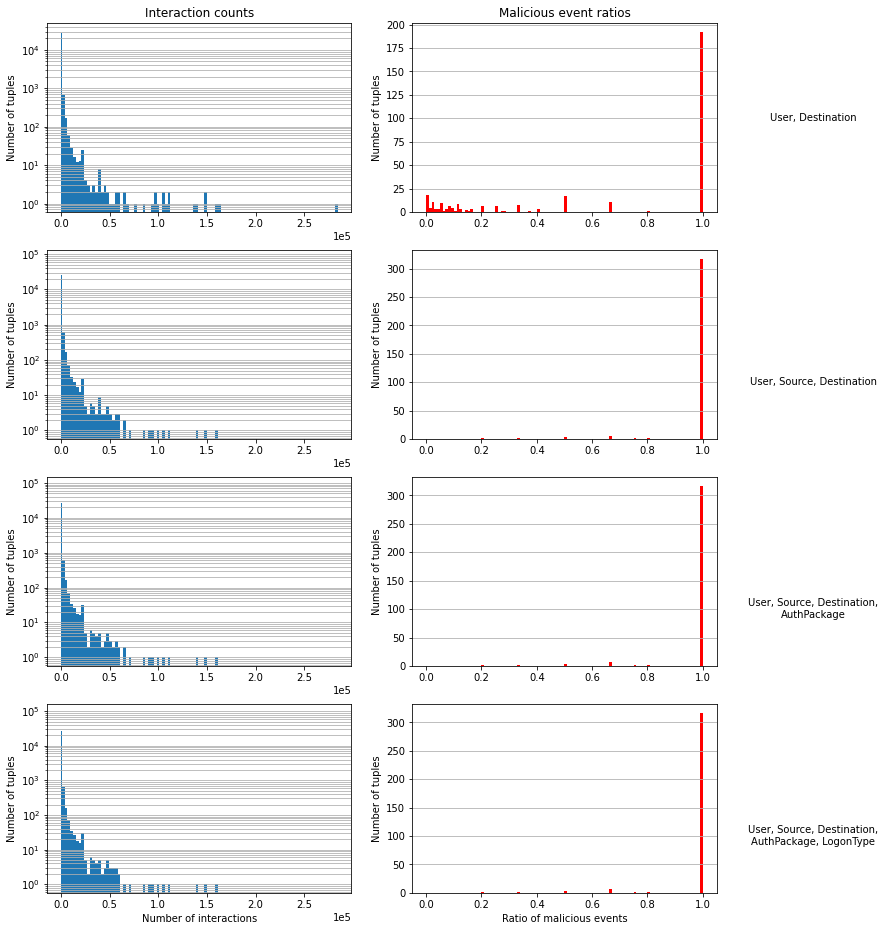

In [6]:
fields = [
    ['User', 'Destination'],
    ['User', 'Source', 'Destination'],
    ['User', 'Source', 'Destination', 'AuthPackage'],
    ['User', 'Source', 'Destination', 'AuthPackage', 'LogonType']
]
n = len(fields)
fig = plt.figure()
axes = fig.subplots(n, 2)
for i in range(n):
    df = select_fields(train, fields[i])
    if i == 0:
        nmax = df['Count'].max()
    axes[i, 0].hist(
        df['Count'],
        bins=np.concatenate([
            [0, 1],
            np.linspace(2, 100, 10),
            np.linspace(1000, nmax, 100)
        ]),
        log=True
    )
    axes[i, 0].ticklabel_format(axis='x', scilimits=(-3, 4))
    axes[i, 0].grid(axis='y', which='both')
    if i >= 1:
        axes[i, 0].set_xlim(axes[0, 0].get_xlim())
    if i == n-1:
        axes[i, 0].set_xlabel('Number of interactions')
    axes[i, 0].set_ylabel('Number of tuples')
    if i == 0:
        axes[i, 0].set_title('Interaction counts')

    df = select_fields(test, fields[i])
    malicious_ratios = df[df['Malicious']>0].apply(
        lambda x: x['Malicious']/x['Count'],
        axis=1)
    axes[i, 1].hist(malicious_ratios, bins=np.linspace(0, 1, 101), color='red')
    if i == n-1:
        axes[i, 1].set_xlabel('Ratio of malicious events')
    axes[i, 1].set_ylabel('Number of tuples')
    if i == 0:
        axes[i, 1].set_title('Malicious event ratios')
    axes[i, 1].grid(axis='y')
    
    name = ',\n'.join([', '.join(fields[i][j:j+3]) for j in range(0, len(fields[i]), 3)])
    axes[i, 1].text(1.4, 100, name, ha='center', va='center')

fig.set_size_inches(12, 16)
plt.show()

Note that the first row (user and destination host) corresponds to the user-host matrices we studied in the previous notebook.
Factoring in the source host makes a clear difference: the event count distribution is shifted towards 0 and, more importantly, an overwhelming proportion of malicious tuples are exclusively involved in malicious events in the test period.
Adding the authentication package and logon type leads to less sensible changes in both distributions.
Overall, this looks promising: aggregating events by (user, source, destination) triplet already draws a clear separation between benign and malicious events.
All we need is a model that can approximate this separation.

The model we use here is called Poisson Tensor Factorization (PTF&nbsp;[CK12]), which should remind you of the Hierarchical Poisson Factorization method from the previous notebook.
The idea is essentially the same, except that the model is adapted to tensors and isn't hierarchical (which you probably guessed from the name).
Given an $m$-mode binary tensor $\mathscr{Y}\in\{0,1\}^{n_1\times\ldots\times{n}_m}$, with $y_{i_1\ldots{i}_m}$ denoting the entry at location $(i_1,\ldots,i_m)$, the PTF model is defined as

$y_{i_1\ldots{i}_m}\sim\mathrm{Poisson}(\lambda_{i_1\ldots{i}_m})$, where
$\lambda_{i_1\ldots{i}_m}=\sum_{k=1}^d\gamma_k\prod_{j=1}^m\theta^{(j)}_{k,i_j}$.

Things are becoming somewhat intricate, so let's take a moment to discuss these equations.
The underlying idea is roughly the same as HPF: a $d$-dimensional, non-negative latent factor
$\big[\theta^{(j)}_{1,i_j},\ldots,\theta^{(j)}_{d,i_j}\big]$ is assigned to the $i_j$-th entity along the $j$-th mode, and the existence of an interaction between entities $i_1,\ldots,i_m$ depends on the element-wise product of their latent factors.
The coefficient $\gamma_k$ is the weight of the $k$-th latent dimension, and each global vector
$\boldsymbol\theta^{(j)}_k=\big[\theta^{(j)}_{k,1},\ldots,\theta^{(j)}_{k,n_j}\big]$ is constrained to have unit norm.
Note that PTF is a straightforward extension of the standard CP (CANDECOMP/PARAFAC) decomposition, the only difference being the use of Poisson regression instead of its linear counterpart.

The use of PTF for intrusion detection in authentication logs has been proposed by Eren et al.&nbsp;[EMA20].
We use their implementation of the model in what follows.
The anomaly detection methodology is the same as in the previous notebook: we fit the latent factors on the training tensor, then use them to find unlikely interactions in the test tensor.
We thus have the same problem as before with entities appearing at test time and not during training: their latent factors have to be initialized.
Here, we do so through averaging-based imputation.

In [7]:
def evaluate_ptf(train, test, n_comp, seed=None):
    X_train_c = train.to_numpy()[:,:-2]
    X_train_v = np.array([int(x>0) for x in train['Count']])
    mean = int(X_train_c.max(0).prod()/X_train_v.sum())
    X_train_v *= mean
    X_test_c = test.to_numpy()[:,:-2]
    X_test_v = np.array([int(x>0) for x in test['Count']])
    y_test = np.array([int(x>0) for x in test['Malicious']])
    y_pred = []
    for k in n_comp:
        ptf = CP_APR(
            method='numpy',
            n_iters=50,
            verbose=0,
            random_state=seed
        )
        ptf.fit(
            coords=X_train_c,
            values=X_train_v,
            rank=[1, k]
        )
        for i in range(X_train_c.shape[1]):
            diff = X_test_c[:,i].max() - X_train_c[:,i].max()
            if diff > 0:
                for j in range(2):
                    fac = ptf.M[j]['Factors'][str(i)]
                    if fac.ndim == 2:
                        to_add = np.tile(
                            fac.mean(0),
                            (diff, 1)
                        )
                    else:
                        to_add = fac.mean(0)*np.ones(diff)
                    ptf.M[j]['Factors'][str(i)] = np.concatenate(
                        [fac, to_add],
                        axis=0
                    )
        y_pred.append(
            1-ptf.predict_scores(
                coords=X_test_c,
                values=X_test_v
            )
        )
    y_pred = np.stack(y_pred, axis=1)
    evaluate_algo(y_test, y_pred, names=['$d$={0}'.format(k) for k in n_comp])
    return y_test, y_pred

In [8]:
n_comp = (10, 50, 100)

Let's see how this works.
We first include three fields into the model: user, source host, and destination host.

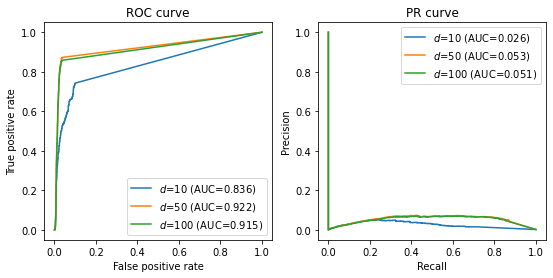

In [9]:
train_usd = select_fields(train, ['User', 'Source', 'Destination'])
test_usd = select_fields(test, ['User', 'Source', 'Destination'])
y_test, y_pred = evaluate_ptf(train_usd, test_usd, n_comp, seed=seed)

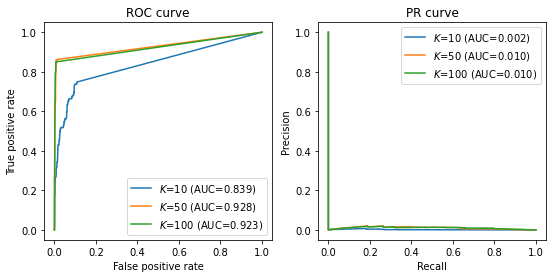

In [10]:
evaluate_algo_events(
    y_pred, test_usd['Count'].to_numpy(), test_usd['Malicious'].to_numpy(),
    names=['$K$={0}'.format(k) for k in n_comp])

Looks like we've finally beaten user-based aggregation!
Note that many events get an identical score, especially for large values of the latent dimension $d$ (as indicated by the linear portions of the ROC curve for FPR greater than a small threshold).
This could be indicative of a numerical underflow, and it prevents the model from properly detecting approximately 15% of the malicious events.

We now add the authentication package to the considered fields.

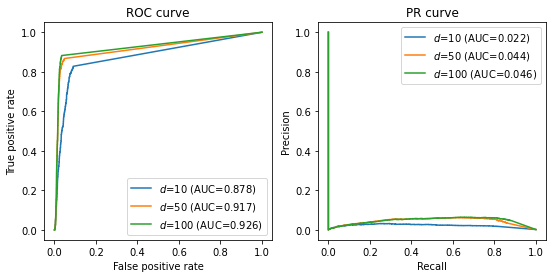

In [11]:
train_usda = select_fields(train, ['User', 'Source', 'Destination', 'AuthPackage'])
test_usda = select_fields(test, ['User', 'Source', 'Destination', 'AuthPackage'])
y_test, y_pred = evaluate_ptf(train_usda, test_usda, n_comp, seed=seed)

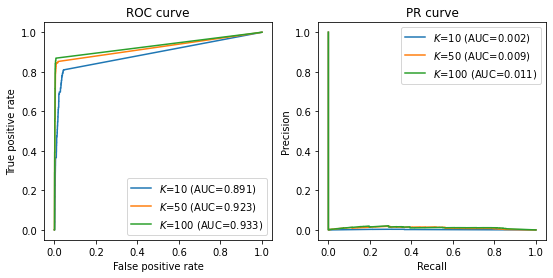

In [12]:
evaluate_algo_events(
    y_pred, test_usda['Count'].to_numpy(), test_usda['Malicious'].to_numpy(),
    names=['$K$={0}'.format(k) for k in n_comp])

We get a sensible increase in detection performance.
Note that increasing the latent dimension $d$ beyond 50 now improves the results, which makes sense: with more information to account for, the model can use the additional parameters to achieve a better fit.
Let's finally see if adding one more dimension leads (namely, the logon type) to further improvement.

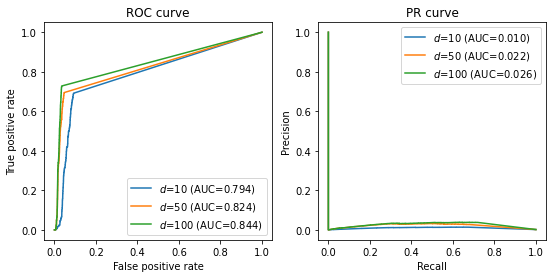

In [13]:
train_usdat = select_fields(train, ['User', 'Source', 'Destination', 'AuthPackage', 'LogonType'])
test_usdat = select_fields(test, ['User', 'Source', 'Destination', 'AuthPackage', 'LogonType'])
y_test, y_pred = evaluate_ptf(train_usdat, test_usdat, n_comp, seed=seed)

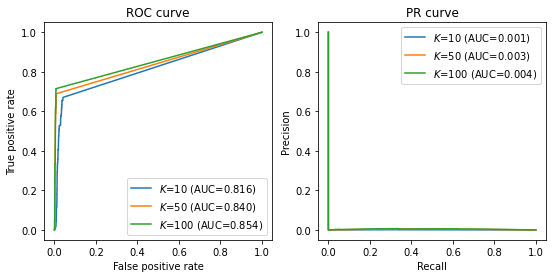

In [14]:
evaluate_algo_events(
    y_pred, test_usdat['Count'].to_numpy(), test_usdat['Malicious'].to_numpy(),
    names=['$K$={0}'.format(k) for k in n_comp])

Nope, looks like we've hit the ceiling: beyond a certain threshold, including more information into our data representation no longer increases performance.
In particular, the model "saturates" (or underflows) at a smaller TPR than before.
A possible explanation for this lies in the structure of the model: the Poisson rate of each possible interaction depends on a sum of $m$-way products, where $m$ still denotes the number of modes of the considered tensor.
Each one of these products becomes more and more likely to underflow as $m$ grows large, which can in turn damage the model's accuracy.
This is an intrinsic limit of PTF, and overcoming it requires a more sophisticated model with the ability to exploit the dependence structure between the fields of each event to simplify the computation of the probability of each interaction.

Despite this last result, tensor factorization appears to be an effective method for event log analysis &mdash; it is the best-performing approach among those presented in this tutorial.
If anything, this demonstrates the importance of data representation: what differentiates the various methods we saw is their ability to transcribe relevant information in mathematical terms.
The key takeaway here is that choosing a mathematical representation amounts to making assumptions on what we're trying to detect: for instance, aggregating events by user only works if intrusions are assumed to trigger significant changes in user behavior &mdash; which, as we discussed earlier, is not always the case.
Making these assumptions explicit can be a good way to assess the relevance of a given method.

### Further reading

Tensor decomposition is just one of the many existing approaches to modelling categorical data &mdash; that is, data that can be seen as draws from a collection of $m$ random variables $A_1,\ldots,A_m$, each of which can take a finite number of values.
Focusing on the anomaly detection side of things, the main difficulty comes from the high dimensionality of the data: basically, in a high-dimensional space, everyone is an outlier.
The main goal of categorical anomaly detection algorithms is thus to extract a sparse representation of normal data.
This implies finding significant statistical dependencies between the $A_i$, which can for instance be done using simple metrics such as the mutual information&nbsp;[DS07], more sophisticated information-theoretic approaches relying on codes and description lengths&nbsp;[ATVF12] or association rule mining (ARM) algorithms&nbsp;[NK08].

Deep learning-based approaches have been proposed as well.
Not unlike tensor decomposition, they rely on the idea of learning an embedding for each entity (i.e., each possible value of each one of the $A_i$), then computing the anomaly score of each interaction using these embeddings.
They do, however, differ in the design of the anomaly scoring function.
For instance, Chen et al.&nbsp;[CTS$^+$16] model the joint probability distribution of $(A_1,\ldots,A_m)$ by applying a softmax function to the weighted sum of pairwise dot products between the embeddings,

$p(a_1,\ldots,a_m)\propto\exp\bigg(\sum_{1\leq{i}<j\leq{m}}w_{ij}g(a_i)\cdot{g}(a_j)\bigg)$, where $g$ maps each entity onto its embedding.

Building upon this model, Amin et al.&nbsp;[AGC19] proposed to sparsify the dependence structure by decomposing the joint probability distribution into a product of conditional distributions,

$p(a_{C+1},\ldots,a_m\mid{a}_1,\ldots,a_C)=\prod_{i=C+1}^mp(a_i\mid{a}_1,\ldots,a_{i-1})$, where $C$ denotes the number of so-called context entities.

Each conditional distribution is then modelled as

$p(a_i\mid{a}_1,\ldots,a_{i-1})\propto\exp\bigg(\sum_{j=1}^{i-1}w_{ij}g(a_j)\cdot{h}(a_i)\bigg)$, where $g,h$ are two distinct embedding maps.

Finally, recent contributions in intrusion detection&nbsp;[DTN20, GE21] have proposed to use auto-encoders for categorical anomaly detection.
To that end, they jointly learn an entity embedding map, an encoder which maps the concatenated embeddings onto a compressed representation, and a decoder which reconstructs the original categorical variables based on this hidden representation.
The reconstruction error can then be used for anomaly detection.


### References

[AGC19] Mohammad Ruhul Amin, Pranav Garg, and Baris Coskun. CADENCE: Conditional Anomaly Detection for Events Using Noise Contrastive Estimation. In _AISec_, 2019.

[ATVF12] Leman Akoglu, Hanghang Tong, Jilles Vreeken, and Christos Faloutsos. Fast and Reliable Anomaly Detection in Categorical Data. In _CIKM_, 2012.

[CK12] Eric Chi and Tamara Kolda. On Tensors, Sparsity, and Nonnegative Factorizations. _SIAM Journal on Matrix Analysis and Applications_, 33(4):1272&ndash;1299, 2012.

[CTS$^+$16] Ting Chen, Lu-An Tang, Yizhou Sun, Zhengzhang Chen, and Kai Zhang. Entity Embedding-Based Anomaly Detection for Heterogeneous Categorical Events. In _IJCAI_, 2016.

[DS07] Kaustav Das and Jeff Schneider. Detecting Anomalous Records in Categorical Datasets. In _KDD_, 2007.

[DTN20] Alexandre Dey, Eric Totel, and Sylvain Navers. Heterogeneous Security Events Prioritization Using Auto-Encoders. In _CRiSIS_, 2020.

[EMA20] Maksim Eren, Juston Moore, and Boian Alexandrov. Multi-Dimensional Anomalous Entity Detection via Poisson Tensor Factorization. In _ISI_, 2020.

[GE21] Andrew Golczynski and John Emanuello. End-to-End Anomaly Detection for Identifying Malicious Cyber Behavior through NLP-Based Log Embeddings. In _IJCAI Workshops_, 2021.


[NK08] Kazuyo Narita and Hiroyuki Kitagawa. Detecting Outliers in Categorical Record Databases Based on Attribute Associations. In _APWeb_, 2008.